### Student Information
Name: 羅心

Student ID: 108062306

GitHub ID: losh0427

Kaggle name: losh

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

---

1. Import lib

In [1]:
import os
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.decomposition import PCA
import math
import itertools
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger
import gensim
import warnings
warnings.filterwarnings('ignore')
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
import ssl
import urllib.request


2. load data

In [2]:
data_id_path = '../../data_identification.csv'
emotion_path = '../../emotion.csv'
sample_submission_path = '../../sampleSubmission.csv'
tweets_path = '../../tweets_DM.json'

In [3]:
data_id = pd.read_csv(data_id_path)
emotion = pd.read_csv(emotion_path)
sample_submission = pd.read_csv(sample_submission_path)
tweets = pd.read_json(tweets_path, lines=True)


In [4]:
#preprocessing tweets
tweets_source = pd.DataFrame(tweets['_source'])
#split hashtags tweet_id text
tweets_source['tweet_id'] = tweets_source['_source'].apply(lambda x: x['tweet']['tweet_id'])
tweets_source['text'] = tweets_source['_source'].apply(lambda x: x['tweet']['text'])
tweets_source['hashtags'] = tweets_source['_source'].apply(lambda x: x['tweet']['hashtags'])
tweets_source = tweets_source.drop(['_source'], axis=1)
tweets_source = tweets_source.rename(columns={'tweet_id': 'id'})
display(tweets_source.head())
display(tweets_source.shape)


,id,text,hashtags
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat]
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]"
2,0x28b412,"Confident of your obedience, I write to you, k...",[bibleverse]
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[]
4,0x2de201,"""Trust is not the same as faith. A friend is s...",[]


(1867535, 3)

In [5]:
#preprocessing data_id
#split train test
train_tweets = data_id[data_id['identification'] == 'train']
test_tweets = data_id[data_id['identification'] == 'test']
#drop
train_tweets = train_tweets.drop(['identification'], axis=1)
test_tweets = test_tweets.drop(['identification'], axis=1)
train_tweets = train_tweets.rename(columns={'tweet_id': 'id'})
test_tweets = test_tweets.rename(columns={'tweet_id': 'id'})

display(train_tweets.shape)
display(test_tweets.shape)
display(train_tweets.shape[0] + test_tweets.shape[0])

(1455563, 1)

(411972, 1)

1867535

In [6]:
#preprocessing emotion
emotion = emotion.rename(columns={'tweet_id': 'id'})

display(emotion.head())
display(emotion.shape)

,id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


(1455563, 2)

3. data  rebuild    
data_identification:id , training or testing    
tweets_DM: id , text , (hastag)     
emotion: id , emotion (training data)    
(sampleSubmission: deal the main output id)    
    => training_df , testing_df    

In [7]:
training_df = []
testing_df = []

In [8]:

#merge into training_df and testing_df
training_df = pd.merge(train_tweets, emotion, on='id')
training_df = pd.merge(training_df, tweets_source, on='id')
testing_df = pd.merge(sample_submission, tweets_source, on='id')

#drop emotion in testing_df
testing_df = testing_df.drop(['emotion'], axis=1)
#drop id in training_df and testing_df
training_df = training_df.drop(['id'], axis=1)
testing_df = testing_df.drop(['id'], axis=1)


display(training_df.shape)
display(testing_df.shape)
display(training_df.head())
display(testing_df.head())
display(sample_submission)


(1455563, 3)

(411972, 2)

,emotion,text,hashtags
0,joy,Huge Respect🖒 @JohnnyVegasReal talking about l...,[]
1,joy,Yoooo we hit all our monthly goals with the ne...,"[spateradio, app]"
2,trust,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,[]
3,joy,Come join @ambushman27 on #PUBG while he striv...,"[PUBG, GamersUnite, twitch, BeHealthy, StayPos..."
4,anticipation,@fanshixieen2014 Blessings!My #strength little...,"[strength, bones, God]"


,text,hashtags
0,When your friends offer to bring you food 😭💘 #...,"[loyal, real]"
1,I've never let any money problems stop me.. I ...,[]
2,@KurtSchlichter Being a Hobby Historian Chelse...,[]
3,#Cannabis offers a natural alternative treatme...,"[Cannabis, Marijuana, Weed, Hemp, Medicine, Le..."
4,Last Friday off before school starts. I'm read...,[FridayFeeling]


,id,emotion
0,0x2c7743,surprise
1,0x2c1eed,surprise
2,0x2826ea,surprise
3,0x356d9a,surprise
4,0x20fd95,surprise
...,...,...
411967,0x351857,surprise
411968,0x2c028e,surprise
411969,0x1f2430,surprise
411970,0x2be24e,surprise


4. EDA

<Axes: xlabel='count', ylabel='emotion'>

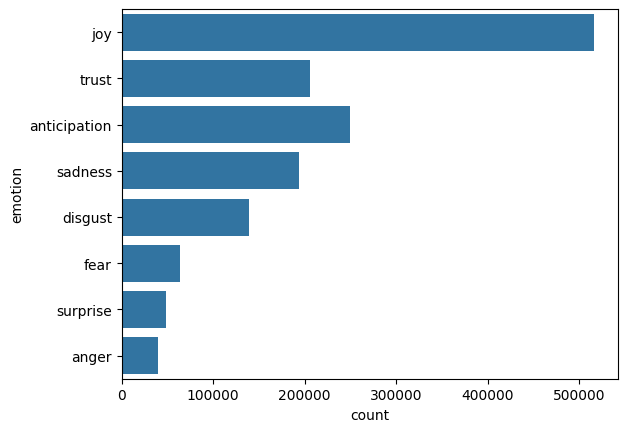

In [9]:
#show the distribution of emotion
sns.countplot(training_df['emotion'])



In [10]:
training_df = training_df.sample(frac=1)

In [11]:
#bow
vectorizer = CountVectorizer()
vectorizer.fit(training_df['text'])
X_train_bow = vectorizer.transform(training_df['text'])
display(X_train_bow.shape)

(1455563, 794247)

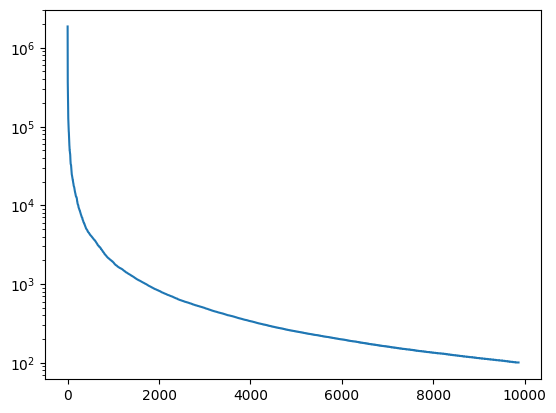

In [12]:
#plot the sum of each word using line chart and sort by the sum in descending order
sum_words = X_train_bow.sum(axis=0)
sum_words = sorted(sum_words.tolist()[0], reverse=True)
# sum_words_2000 is the elenment larger than 2000
sum_words_ = [x for x in sum_words if x > 100]
plt.plot(sum_words_)
plt.yscale('log')
# plt.plot(sum_words[:20000])
# plt.yscale('log')

In [13]:
#plot X_train_bow distribution and sort by frequency of words in descending order  
sum_words = X_train_bow.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq = pd.DataFrame(words_freq, columns=['word', 'freq'])


,word,freq
0,lh,1862300
1,the,556497
2,to,458632
3,you,366967
4,and,318035


(794247, 2)

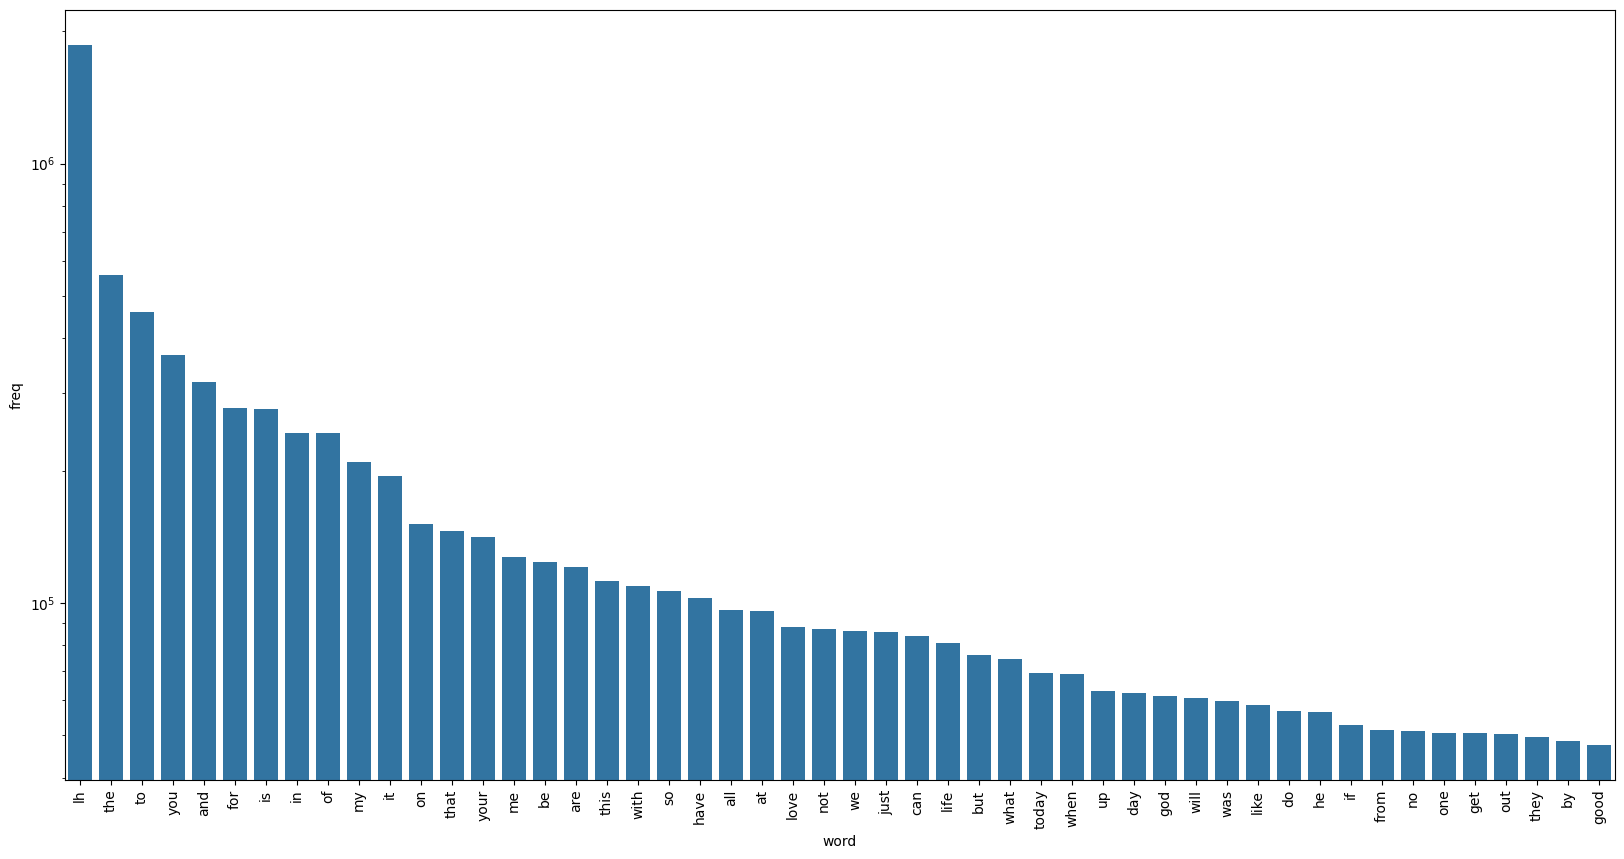

In [15]:
display(words_freq.head())
display(words_freq.shape)
#top50 words
plt.figure(figsize=(20, 10))
sns.barplot(x='word', y='freq', data=words_freq[:50])
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

5. Feature engineering      
Main : Scentence vector     
Bag of Word     
Word to Vector        
Cluster     
...

In [16]:
#bow_500
bow_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)
bow_500.fit(training_df['text'])
bow_500_train = bow_500.transform(training_df['text'])


c:\Users\lo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
#bow_1000
bow_1000 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)
bow_1000.fit(training_df['text'])
bow_1000_train = bow_1000.transform(training_df['text'])

c:\Users\lo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
#bow_5000
bow_5000 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)
bow_5000.fit(training_df['text'])
bow_5000_train = bow_5000.transform(training_df['text'])

In [19]:
#bow_10000
bow_10000 = CountVectorizer(max_features=10000, tokenizer=nltk.word_tokenize)
bow_10000.fit(training_df['text'])
bow_10000_train = bow_10000.transform(training_df['text'])



6. Split train & val

In [64]:
#split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(bow_10000_train, training_df['emotion'], test_size=0.2, random_state=42)
#label encode the emotion
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
label_encoded_y_train = label_encoder.transform(y_train)
label_encoded_y_val = label_encoder.transform(y_val)
#count unique number label_encoded_y_train
unique, counts = np.unique(label_encoded_y_train, return_counts=True)
y_count = dict(zip(unique, counts))
#calculate the weight of each label
weight = []
for i in range(len(y_count)):
    weight.append(int((sum(y_count.values())/y_count[i]).round(0)))
display(weight)
#change to dic
weight_dic = dict(zip(unique, weight))

[37, 6, 10, 23, 3, 8, 30, 7]

7. Model build and training

In [65]:
#use xgboost to train the model
import dis
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# #train the model
xgb_model  = xgb.XGBClassifier(objective="multi:softprob", random_state=42, max_depth=10, n_estimators=1000, learning_rate=0.1, n_jobs=-1,  device="cuda")
xgb_model.fit(X_train, label_encoded_y_train)
#predict the validation data
label_y_pred = xgb_model.predict(X_val)
#decode the emotion
y_pred = label_encoder.inverse_transform(label_y_pred)
#calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#calculate the classification report
print(classification_report(y_val, y_pred))


Accuracy: 56.40%
              precision    recall  f1-score   support

       anger       0.68      0.25      0.36      8094
anticipation       0.70      0.50      0.58     49866
     disgust       0.51      0.35      0.42     27660
        fear       0.79      0.38      0.52     12749
         joy       0.52      0.87      0.65    102987
     sadness       0.55      0.47      0.51     38956
    surprise       0.77      0.23      0.35      9804
       trust       0.68      0.29      0.41     40997

    accuracy                           0.56    291113
   macro avg       0.65      0.42      0.48    291113
weighted avg       0.60      0.56      0.54    291113



In [44]:
#lightGBM
import lightgbm as lgb
#chagne type to np.float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
# weight_dic = dict(zip(unique.astype(np.float64) , weight.astype(np.float64)))

#train the model
lgb_model = lgb.LGBMClassifier(objective='multiclass', random_state=42, max_depth=10, n_estimators=1000, learning_rate=0.1, n_jobs=-1,  class_weight=weight_dic)
lgb_model.fit(X_train, label_encoded_y_train)
#predict the validation data
label_y_pred = lgb_model.predict(X_val)
#decode the emotion
y_pred = label_encoder.inverse_transform(label_y_pred)
#calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#calculate the classification report
print(classification_report(y_val, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 1164450, number of used features: 500
[LightGBM] [Info] Start training from score -2.085000
[LightGBM] [Info] Start training from score -2.069124
[LightGBM] [Info] Start training from score -2.138454
[LightGBM] [Info] Start training from score -2.082325
[LightGBM] [Info] Start training from score -2.032402
[LightGBM] [Info] Start training from score -2.035022
[LightGBM] [Info] Start training from score -2.091701
[Light

In [47]:
#random forest
from sklearn.ensemble import RandomForestClassifier
#train the model
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42, n_jobs=-1, class_weight=weight_dic)
rf_model.fit(X_train, label_encoded_y_train)
#predict the validation data
label_y_pred = rf_model.predict(X_val)
#decode the emotion
y_pred = label_encoder.inverse_transform(label_y_pred)
#calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#calculate the classification report
print(classification_report(y_val, y_pred))

Accuracy: 32.14%
              precision    recall  f1-score   support

       anger       0.05      0.36      0.09      8094
anticipation       0.64      0.32      0.43     49866
     disgust       0.33      0.17      0.23     27660
        fear       0.10      0.37      0.16     12749
         joy       0.61      0.36      0.45    102987
     sadness       0.26      0.48      0.34     38956
    surprise       0.53      0.15      0.23      9804
       trust       0.47      0.20      0.28     40997

    accuracy                           0.32    291113
   macro avg       0.38      0.30      0.28    291113
weighted avg       0.48      0.32      0.36    291113



8. Evalutaion

In [67]:
display(X_train.shape)

(1164450, 10000)

9. Output

In [66]:
# change the testing_df to be adapt to the model
X_test = bow_10000.transform(testing_df['text'])
# X_test = bow_5000.transform(testing_df['text'])
label_y_pred = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(label_y_pred)


KeyboardInterrupt: 

In [40]:
#output the result
sample_submission.drop(['emotion'], axis=1, inplace=True)
sample_submission['emotion'] = y_pred
#the first row is the column name
sample_submission.to_csv('submission.csv', index=False)
